# Example 2: Fault correlation through time steps of 2-D numerical model
This example describes how to correlate faults extracted at different time steps.

## Setup

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
6. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.

## Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install them:

In [1]:
!pip3 install git+https://github.com/thilowrona/fatbox.git

  Cloning https://github.com/thilowrona/fatbox.git to /tmp/pip-req-build-xbk90cdz
  Running command git clone -q https://github.com/thilowrona/fatbox.git /tmp/pip-req-build-xbk90cdz
     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 103.4MB 89kB/s 
  Cloning https://github.com/ulikoehler/cv_algorithms.git to /tmp/pip-install-9yie6mtu/cv-algorithms
  Running command git clone -q https://github.com/ulikoehler/cv_algorithms.git /tmp/pip-install-9yie6mtu/cv-algorithms
  Created wheel for fatbox: filename=fatbox-0.0.1-cp37-none-any.whl size=25852 sha256=2b63d35063436015f4f3a8c0357af5d09a371345c9d00e45d13904f3aeba780e
  Stored in directory: /tmp/pip-ephem-wheel-cache-c1ddm7im/wheels/3c/75/06/4f57a6a85e140ffdf1280b29ebde7d5e62277dfc68e4aeb466
  Created wheel for network: filename=network-0.1-cp37-none-any.whl size=3157 sha256=0309f172b15eab73a37d2d71d7556d5d6e4e9e319479dc20f2478896389048c5
  Stored in directory: /root/.cache/pip/wheels/f6/e7/6a/7098

and get the tutorials:

In [2]:
!git clone https://github.com/thilowrona/fatbox_tutorials

Cloning into 'fatbox_tutorials'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 292 (delta 36), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (292/292), 30.11 MiB | 14.75 MiB/s, done.
Resolving deltas: 100% (107/107), done.


Now we can load the python packages:

In [3]:
import math
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from ipywidgets import Layout, interactive, widgets
from tqdm import tqdm

from fatbox.metrics import total_length
from fatbox.plots import plot_components, plot_attribute, plot_faults

## Load and visualize networks

First, we load our fault networks extracted from a 2-D model over several timesteps:

In [5]:
Gs = []
for n in range(3,50):
  Gs.append(pickle.load(open('/content/fatbox_tutorials/3-time_stepping/graphs/g_'+ str(n) + '.p', 'rb')))

Now we can visualize and compare the faults extracted through time:

In [6]:
%matplotlib inline
from ipywidgets import interactive, widgets, Layout


def f(time):
    fig, ax = plt.subplots(figsize=(16,4))
    plot_components(Gs[time], ax, label=True)
    plt.xlim([1000, 3500])
    plt.ylim([600, 0])
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=3, max=49, step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot


interactive(children=(IntSlider(value=3, description='time', layout=Layout(width='900px'), max=49, min=3), Out…

The faults have different labels in every time steps. That's a result of the extraction, where arbitrary labels are assigned to the faults. To track faults through time, we want these labels to be consistent between time steps. So let's look at two consecutive time steps:

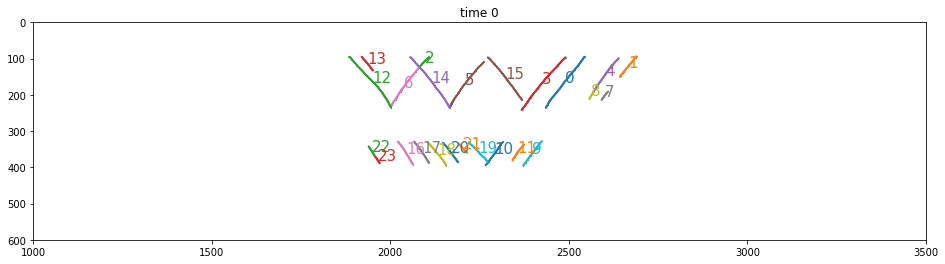

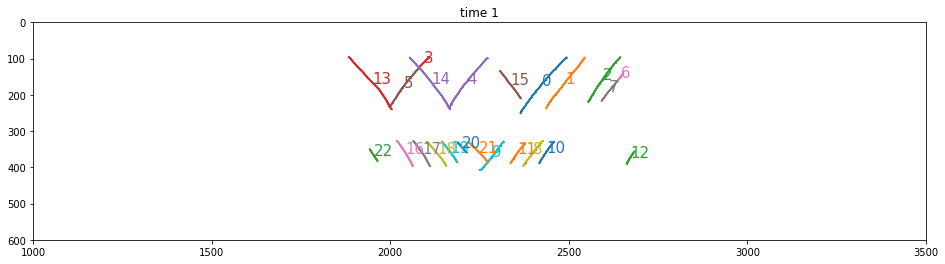

In [7]:
G_0 = Gs[0]
G_1 = Gs[1]

fig, ax = plt.subplots(figsize=(16,4))
plot_components(G_0, ax, label=True)
plt.title('time 0')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

fig, ax = plt.subplots(figsize=(16,4))
plt.title('time 1')
plot_components(G_1, ax, label=True)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

## Correlate two time steps

We can already see that the green fault 12 at time 0 is probably the same as the red fault 13 at time 1. So in order to match them, we will compare all faults between two time steps and re-label them.

But first we will introduce a new label. We typically extract faults as components of the graph (i.e. nodes connected to one another). But geological faults can consist of multiple of such components, such as faults 22 and 23 at time 0 - they probably belong to one fault. So let's introduce this new fault label:

In [8]:
for node in G_0:
    G_0.nodes[node]['fault'] = G_0.nodes[node]['component']

for node in G_1:
    G_1.nodes[node]['fault'] = G_1.nodes[node]['component']

print(G_0.nodes[0])

{'pos': (2544, 95), 'component': 0, 'polarity': 0, 'edges': 2, 'fault': 0}


Now each node has an additional property 'fault' that we will re-label later on. But first we want to get the fault labels for the first two time steps:

In [9]:
def get_fault_labels(G):
    labels=set()
    for node in G:
        labels.add(G.nodes[node]['fault'])
    return sorted(list(labels))

fault_labels_0 = get_fault_labels(G_0)
fault_labels_1 = get_fault_labels(G_1)

print(fault_labels_0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


You can check that these are all the faults labelled in the image above.

Next we want to get the polarities of the faults, i.e. dipping to the left or the right. We computed the polarity during the extraction to help us differentiate cross-cutting faults.

In [10]:
def get_fault(G, n):
    nodes = [node for node in G if G.nodes[node]['fault']==n]
    return G.subgraph(nodes)

def get_polarity(G):
    for node in G:
        polarity = G.nodes[node]['polarity']
        break
    return polarity

def get_fault_polarities(G):
    labels = get_fault_labels(G)
    polarities=[]
    for label in labels:            
        G_fault = get_fault(G, label)
        polarities.append(get_polarity(G_fault))
    return polarities

fault_polarities_0 = get_fault_polarities(G_0)
fault_polarities_1 = get_fault_polarities(G_1)

print('faults')
print(fault_labels_0)
print('polarities')
print(fault_polarities_0)

faults
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
polarities
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Let's check if these polarities are correct:

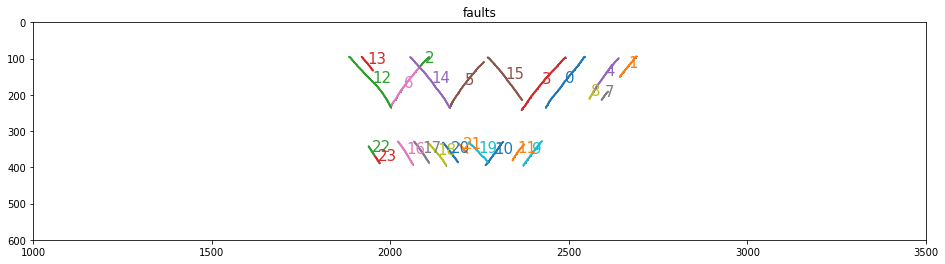

AttributeError: ignored

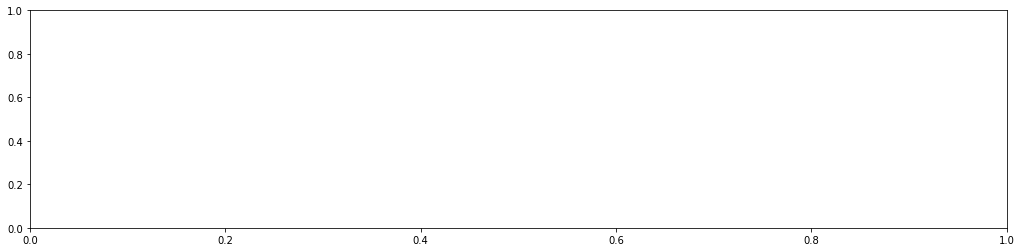

In [11]:
fig, ax = plt.subplots(figsize=(16,4))
plot_components(G_0, ax, label=True)
plt.title('faults')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

fig, ax = plt.subplots(figsize=(17.5,4))
plot_attribute(G_0, 'polarity', ax)
plt.title('polarities')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

Looks alright! Now let's convert our graphs to point clouds, which we can compare easily:

In [12]:
def G_to_pts(G):
    labels = get_fault_labels(G)
    point_set=[]
    for label in labels:            
        G_fault = get_fault(G, label)
        points = []
        for node in G_fault:
            points.append(G_fault.nodes[node]['pos'])
        point_set.append(points)
    return point_set

pt_set_0 = G_to_pts(G_0)
pt_set_1 = G_to_pts(G_1)

Now it's getting interesting. To correlate faults across time steps, we want to check if a fault from the time step 0 is within a fault from time step 1 and vice versa. This allows us to correlate faults even if they merge or split up. We do this by:

1.   Calculating the distance matrix between each node of fault A and B, i.e. the point clouds
2.   Calculating the minimum distance of the closest nodes
3.   Computing the mean of these distances
4.   Using a threshold radius R to decide whether a fault A is within fault B



In [13]:
def is_A_in_B(set_A, set_B, R):    
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      if np.mean(np.min(distances, axis=1)) > R:
          return False
      else:
          return True

Now we use this function for all faults with the same polarities and in both directions (i.e. A is in B, B is in A) between the two time steps:

In [14]:
R = 10

correlations = set()
for n in range(len(fault_labels_0)):
    for m in range(len(fault_labels_1)):
        if fault_polarities_0[n] == fault_polarities_1[m]:
            if is_A_in_B(pt_set_0[n], pt_set_1[m], R):
                correlations.add((fault_labels_0[n], fault_labels_1[m]))
            if is_A_in_B(pt_set_1[m], pt_set_0[n], R):
                correlations.add((fault_labels_0[n], fault_labels_1[m])) 

print(correlations)

{(16, 16), (11, 11), (3, 0), (9, 8), (23, 22), (7, 7), (1, 6), (21, 20), (12, 13), (14, 14), (15, 15), (10, 9), (19, 21), (5, 4), (8, 2), (2, 3), (20, 19), (4, 2), (6, 5), (0, 1), (22, 22), (18, 18), (17, 17)}


We can check if the correlations, we derived are correct. The third correlation for example says that fault 3 at time 0 is the same as fault 0 at time 1. Is that correct?

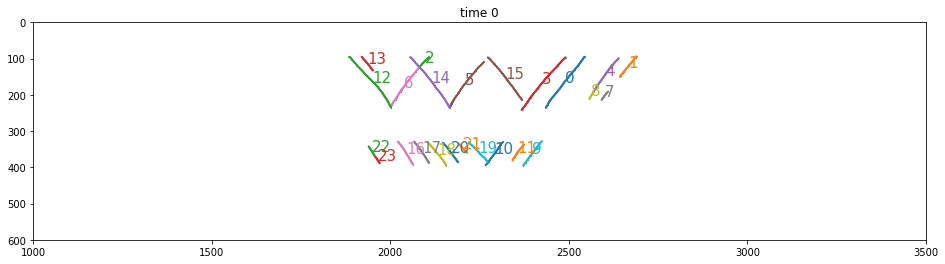

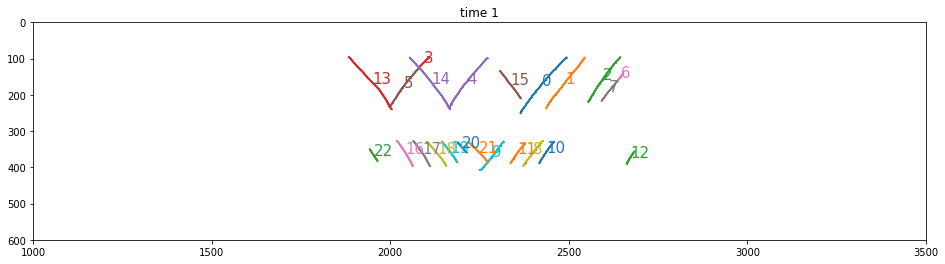

In [15]:
fig, ax = plt.subplots(figsize=(16,4))
plot_components(G_0, ax, label=True)
plt.title('time 0')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

fig, ax = plt.subplots(figsize=(16,4))
plt.title('time 1')
plot_components(G_1, ax, label=True)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

Yeah, looks right! So let's relabel these faults consistently using these correlations. When doing this we need to keep track of the faults, we've correlated. To do this, we first set them all to uncorrelated:

In [16]:
for node in G_1:
    G_1.nodes[node]['correlated']=False

Next, we sort the correlations by fault length, so that when two faults merge, we preserve the larger one.

In [17]:
lengths = [total_length(get_fault(G_0, correlation[0])) for correlation in correlations]
lengths, correlations = zip(*sorted(zip(lengths, correlations)))

Remember you can find all functions such as `total_length` in the folder:

https://github.com/thilowrona/fault_analysis_toolbox/tree/master/code

Now we relabel the faults using correlations:

In [18]:
for node in G_1:
    for correlation in correlations:
        if G_1.nodes[node]['component'] == correlation[1]:
            G_1.nodes[node]['fault'] = correlation[0]
            G_1.nodes[node]['correlated'] = True

Finally, we relabel the uncorrelated faults to avoid confusion:

In [19]:
max_comp = max(get_fault_labels(G_1))

G_1_sub = nx.subgraph(G_1, [node for node in G_1 if G_1.nodes[node]['correlated']==False])  
for label, cc in enumerate(sorted(nx.connected_components(G_1_sub))): 
    for n in cc:
        G_1.nodes[n]['fault'] = label+max_comp+1

Now let's check if it worked:

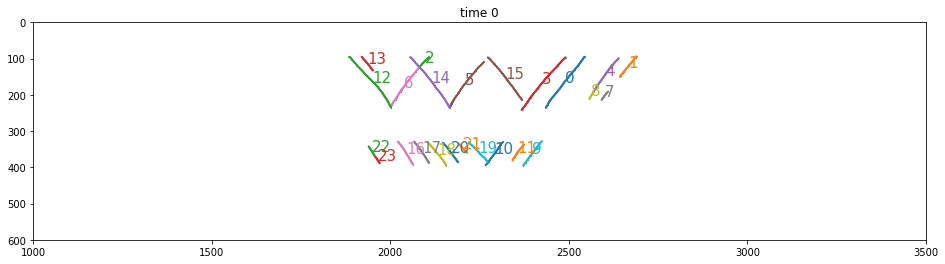

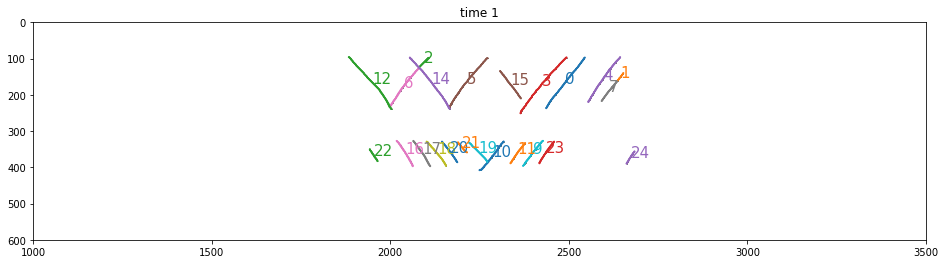

In [20]:
fig, ax = plt.subplots(figsize=(16,4))
plot_faults(G_0, ax, label=True)
plt.title('time 0')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

fig, ax = plt.subplots(figsize=(16,4))
plt.title('time 1')
plot_faults(G_1, ax, label=True)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

Awesome! It worked! You can see that faults in the same location have the same label.

## Correlate multiple time steps
Alright, let's do this for all 50 time steps:

In [21]:
max_comp = 0

for time in tqdm(range(len(Gs)-1)):

  G_0 = Gs[time]
  G_1 = Gs[time+1]

  if n == 0:
    for node in G_0:
      G_0.nodes[node]['fault'] = G_0.nodes[node]['component']   
    Gs[time] = G_0
  
  for node in G_1:
      G_1.nodes[node]['fault'] = G_1.nodes[node]['component']


  # Correlation
  fault_labels_0 = get_fault_labels(G_0)
  fault_labels_1 = get_fault_labels(G_1)
  
  fault_polarities_0 = get_fault_polarities(G_0)
  fault_polarities_1 = get_fault_polarities(G_1)
  
  pt_set_0 = G_to_pts(G_0)
  pt_set_1 = G_to_pts(G_1)


  R = 10
  correlations = set()
  for n in range(len(fault_labels_0)):
      for m in range(len(fault_labels_1)):
          if fault_polarities_0[n] == fault_polarities_1[m]:
              if is_A_in_B(pt_set_0[n], pt_set_1[m], R):
                  correlations.add((fault_labels_0[n], fault_labels_1[m]))
              if is_A_in_B(pt_set_1[m], pt_set_0[n], R):
                  correlations.add((fault_labels_0[n], fault_labels_1[m]))   


  # Relabel
  for node in G_1:
      G_1.nodes[node]['correlated']=False

  lengths = [total_length(get_fault(G_0, correlation[0])) for correlation in correlations]
  lengths, correlations = zip(*sorted(zip(lengths, correlations)))

  for node in G_1:
      for correlation in correlations:
          if G_1.nodes[node]['component'] == correlation[1]:
              G_1.nodes[node]['fault'] = correlation[0]
              G_1.nodes[node]['correlated'] = True

  max_comp = max(get_fault_labels(G_1))

  G_1_sub = nx.subgraph(G_1, [node for node in G_1 if G_1.nodes[node]['correlated']==False])  
  for label, cc in enumerate(sorted(nx.connected_components(G_1_sub))): 
      for n in cc:
          G_1.nodes[n]['fault'] = label+max_comp+1
  

  Gs[time+1] = G_1


100%|██████████| 46/46 [02:14<00:00,  2.93s/it]


and let's look at the results:

In [22]:
%matplotlib inline
from ipywidgets import interactive, widgets, Layout


def f(time):
    fig, ax = plt.subplots(figsize=(16,4))
    plot_faults(Gs[time], ax, label=True)
    plt.xlim([1000, 3500])
    plt.ylim([600, 0])
    plt.show()

interactive_plot = interactive(f, time=widgets.IntSlider(min=3, max=49, step=1, layout=Layout(width='900px')))
output = interactive_plot.children[-1]
output.layout.width = '1000px'
interactive_plot

interactive(children=(IntSlider(value=3, description='time', layout=Layout(width='900px'), max=49, min=3), Out…

Fantastic! Now that we have correlated the faults, we can compute slip and displacement through time to investigate the growth of these faults. The next tutorial shows how to calculate fault slip from velocities.